In [3]:
!pip install geopandas && pip install formulaic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 2.6 MB/s eta 0:00:00


In [4]:
from formulaic import Formula

In [191]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# Procesamiento de datos

In [5]:
datos = pd.read_csv('sube-2023.csv')
datos.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO
2,2023-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1707,NO
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO
4,2023-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1189,NO


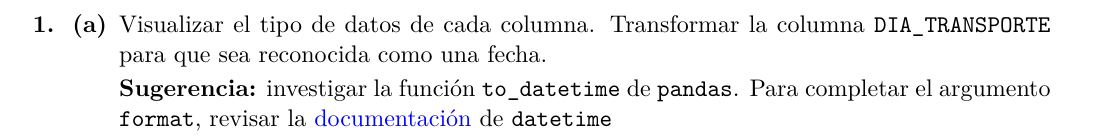

In [6]:
# Convertimos a la columna DIA_TRANSPORTE para que sea reconocida a como una fecha
datos['DIA_TRANSPORTE'] = pd.to_datetime(datos['DIA_TRANSPORTE'], format='%Y-%m-%d')

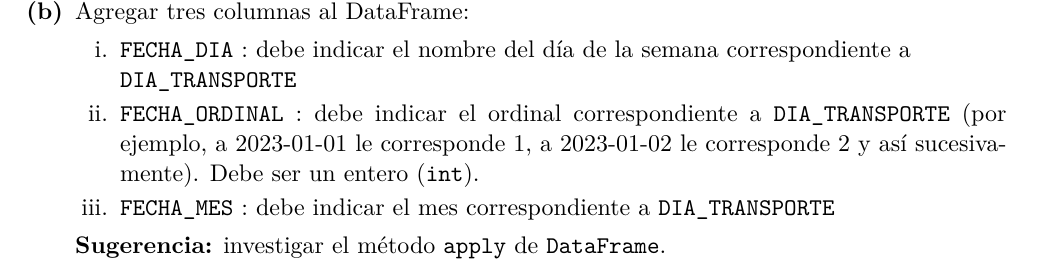

In [7]:
# Agregamos a nuestra DataFrame las columnas indicadas

# Agregamos la columna de fecha_dia con el formato observado en el ejemplo, solamente con 3 carácteres
datos['fecha_dia'] = datos['DIA_TRANSPORTE'].dt.day_name().str[:3]
# Agregamos la columna de fecha_mes en formato 'MM', 2 dígitos para el mes
datos['fecha_mes'] = datos['DIA_TRANSPORTE'].dt.strftime('%m')
# Agregamos la columna de fecha_ordinal indicando el día ordinal del año
datos['fecha_ordinal'] = datos['DIA_TRANSPORTE'].dt.dayofyear

In [ ]:
# Tests
# DIA_TRANSPORTE tiene que ser tipo datetime
assert datos['DIA_TRANSPORTE'].dtype == 'datetime64[ns]'

# Dias de la semana
assert datos['fecha_dia'].drop_duplicates().count() == 7 # Tienen que ser 7 dias distintos

# Tiene que haber 365 dias distintos en el año
assert datos['fecha_ordinal'].drop_duplicates().count() == 365


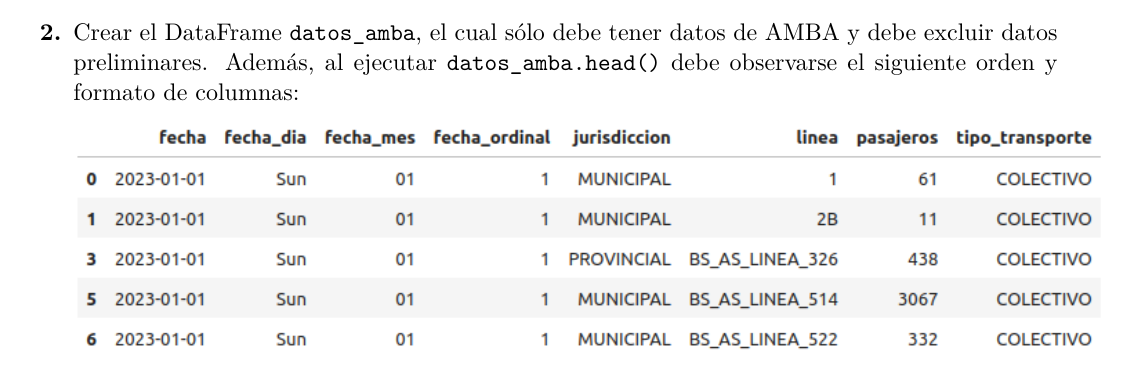

In [8]:
#Creamos un nuevo data frame con los valores a trabajar solicitados.
datos_filtrados = datos[(datos['AMBA'] == 'SI') & (datos['DATO_PRELIMINAR'] == "NO")]

In [9]:
datos_filtrados.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,fecha_dia,fecha_mes,fecha_ordinal
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO,Sun,01,1
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO,Sun,01,1
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO,Sun,01,1
5,2023-01-01,AUTOBUSES BUENOS AIRES S.R.L. – TRANSPORTE LAR...,BS_AS_LINEA_514,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,ALMIRANTE BROWN,3067,NO,Sun,01,1
6,2023-01-01,EL URBANO SRL,BS_AS_LINEA_522,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,LANUS,332,NO,Sun,01,1


In [10]:
#Seleccionamos las columnas correspondientes a visualizar.
column_order  = ['DIA_TRANSPORTE', 'fecha_dia', 'fecha_mes', 'fecha_ordinal', 'JURISDICCION', 'LINEA', 'CANTIDAD', 'TIPO_TRANSPORTE']
datos_filtrados = datos_filtrados[column_order]

In [11]:
#Renombramos las columnas correspondientes y colocamos el formato correcto.
datos_filtrados = datos_filtrados.rename(columns = {"DIA_TRANSPORTE" : "fecha", "CANTIDAD" : "pasajeros"})
#Renombramos las columnas en un formato que sea minúsculas
datos_amba = datos_filtrados.rename(columns = str.lower)

In [12]:
#Visualizamos lo pedido
datos_amba.head()

,fecha,fecha_dia,fecha_mes,fecha_ordinal,jurisdiccion,linea,pasajeros,tipo_transporte
0,2023-01-01,Sun,01,1,MUNICIPAL,1,61,COLECTIVO
1,2023-01-01,Sun,01,1,MUNICIPAL,2B,11,COLECTIVO
3,2023-01-01,Sun,01,1,PROVINCIAL,BS_AS_LINEA_326,438,COLECTIVO
5,2023-01-01,Sun,01,1,MUNICIPAL,BS_AS_LINEA_514,3067,COLECTIVO
6,2023-01-01,Sun,01,1,MUNICIPAL,BS_AS_LINEA_522,332,COLECTIVO


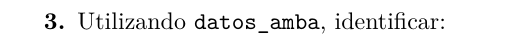

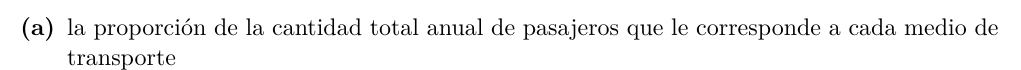

In [13]:
#Realizamos el agrupamiento correspondiente por tipo de transporte y pasajeros, calculando así su proporción
proporcion_transporte = datos_amba.groupby('tipo_transporte')['pasajeros'].sum() / datos_amba['pasajeros'].sum()
print(proporcion_transporte)

tipo_transporte
COLECTIVO    0.837645
SUBTE        0.068097
TREN         0.094258
Name: pasajeros, dtype: float64


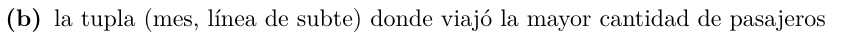

In [14]:
#Creamos un nuevo dataFrame donde sólo estén los datos del tipo de transporte "SUBTE" que se encuentran en el AMBA
subte_data = datos_amba[datos_amba['tipo_transporte'] == 'SUBTE']

In [15]:
#Realizamos las tuplas indicadas y sumamos la cantidad de pasajeros, según el mes y la línea
pasajeros_subte_mes = subte_data.groupby(['fecha_mes','linea'])['pasajeros'].sum()
#Localizamos la tupla con el valor máximo en cantidad de pasajeros
max_pasajeros_subte = pasajeros_subte_mes.idxmax()
#Nos quedamos con el valor que posee la mayor cantidad de pasajeros
max_value = pasajeros_subte_mes.max()
#Imprimimos el mes donde concurrió en el SUBTE la mayor cantidad de pasajeros
print(f"El mes con la mayor cantidad de pasajeros fue: {max_pasajeros_subte[0]}")
#Imprimimos la línea donde concurrió en el SUBTE la mayor cantidad de pasajeros
print(f"La línea de subte que tuvo la mayor cantidad de pasajeros fue : {max_pasajeros_subte[1]}")
#Imprimimos el valor máximo que hubo en cantidad de pasajeros
print(max_value)
#Imprimimos la tupla corresponidente indicada
print(max_pasajeros_subte)

El mes con la mayor cantidad de pasajeros fue: 08
La línea de subte que tuvo la mayor cantidad de pasajeros fue : LINEA_B
5227906
('08', 'LINEA_B')


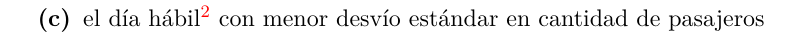

In [16]:
#Realizamos un nuevo DataFrame con los días hábiles a analizar.
días_hábiles = datos_amba[datos_amba['fecha_dia'].isin(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])]
#Realizamos un agrupamiento por días y utilizamos la función std para calcular el desvío entandar en cada día.
desvio_hábiles = días_hábiles.groupby('fecha_dia')['pasajeros'].std()
#Nos quedamos con el valor mínimo.
dia_menor_desvio = desvio_hábiles.idxmin()
print(f"EL día hábil que posee el menor desvío estándar es: {dia_menor_desvio}")

EL día hábil que posee el menor desvío estándar es: Mon


# Análisis Exploratorio
#### Primero vamos a comparar como se distribuyen en argentina la cantidad de pasajeros (comparando por provincia) en el mapa de argentina
##### Queremos hacer un mapa de calor del territorio Argentino que muestre: $$\dfrac{pasajeros}{habitantes}$$

##### Para esto seguimos los siguientes pasos:
1. Importamos el geoJson de argentina y lo guardamos en un DataFrame
1. Guardamos en ese dataframe la cantidad de pasajeros (En sus respectivas provincias)
1. Obtenemos los datos de habitantes por provincia ([Fuente](https://censo.gob.ar/index.php/datos_definitivos/))
1. En el DataFrame calculamos agregamos una nueva columna "cantidad_proporcional" haciendo pasajers/habitantes
1. Finalmente hacemos el mapa de calor!

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import requests


df = gpd.read_file("https://labo-datos-next-psi.vercel.app/api/argentina/map") # Cargo el Mapa de argentina (devuelve un dataframe con columna nombre y las posiciones en el mapa)
datos_mapa = datos[(datos["PROVINCIA"] != "JN") & (datos["TIPO_TRANSPORTE"] == "COLECTIVO")] # Saco los de Jurisdiccion nacional ( no son muy signigicativos en el total 5% aprox)
datos_mapa = datos_mapa.groupby("PROVINCIA").sum("CANTIDAD") # Tomo los totales
df["nombre"] = df["nombre"].apply(str.upper) # pasamos a mayuscula los nombres del GEOJSON para poder comparar con las que ya tenemos
df["cantidad"] = [datos_mapa['CANTIDAD'][provincia] if provincia in datos_mapa.index else 0 for provincia in df["nombre"]] # agrego la columna cantidad al geojson

# Ahora le introducimos la poblacion de cada provincia (FUENTE https://censo.gob.ar/index.php/datos_definitivos/)
url_poblacion = "https://labo-datos-next-psi.vercel.app/api/argentina/poblacion"
response = requests.get(url_poblacion)
data_poblacion = pd.DataFrame(response.json())

# Sumamos CABA a Buenos Aires
habitantes_caba = data_poblacion[data_poblacion["provincia"] == "Ciudad Autónoma de Buenos Aires"]["habitantes"]
data_poblacion.iloc[data_poblacion[data_poblacion["provincia"] == "Buenos Aires"].index, 1] += habitantes_caba.values[0]
data_poblacion["provincia"] = data_poblacion["provincia"].apply(str.upper) # lo pasamos a mayuscula para poder comparar con el geojson
df["habitantes"] = [data_poblacion[data_poblacion["provincia"] == provincia]["habitantes"].values[0] if len(data_poblacion[data_poblacion["provincia"] == provincia]["habitantes"]) else 0  for provincia in df["nombre"]] # calculamos la proporcion de pasajeros por habitante
df["cantidad_proporcional"] = df["cantidad"] / df["habitantes"] # calculamos la proporcion de pasajeros por habitante

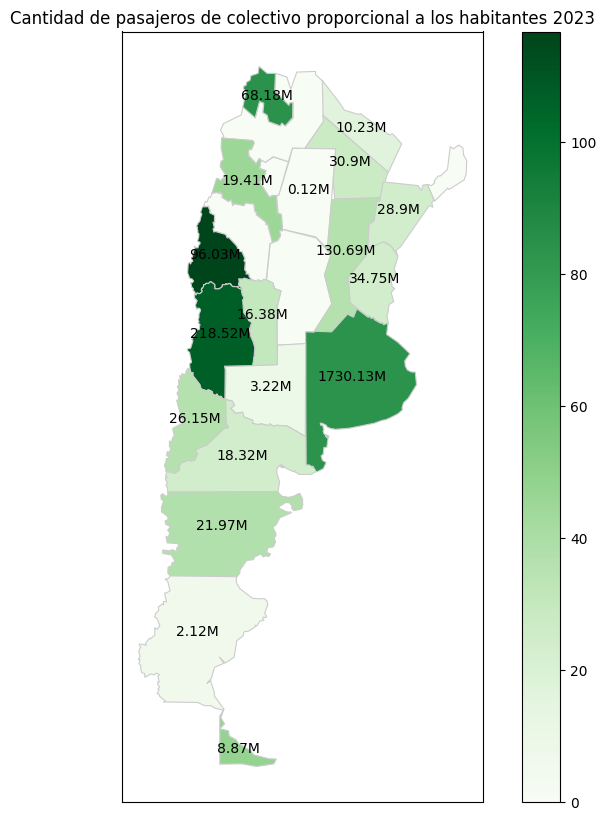

In [ ]:
# Creo las figuras con matplolib ocultando ejes X e Y
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

df.plot(column='cantidad_proporcional', cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

def million_format(n):
    if (n == 0):
        return ""

    return str(round(n/1000000, 2))+"M"

for i, row in df.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, million_format(row['cantidad']), horizontalalignment='center')
plt.title('Cantidad de pasajeros de colectivo proporcional a los habitantes 2023')
plt.show() # ((( No somos antipatria, no aparecen las malvinas por cuestiones del GEOJSON  )))


##### Notemos que BS.AS, Más allá de ser la provincia con mas pasajeros, y por mucha diferencia, en relación a la cantidad de habitantes no es que tiene mayor proporcion de pasajeros.


##### Ahora queremos responder la siguiente pregunta:
 * ¿Cómo varía el uso del transporte público a lo largo del año? ¿Se observa el mismo efecto en AMBA y en el interior del país? ¿Y en todos los medios de transporte por igual?
1. Para eso primero vamos a ver como varia en el AMBA durante el año, por mes y luego por dia de la semana


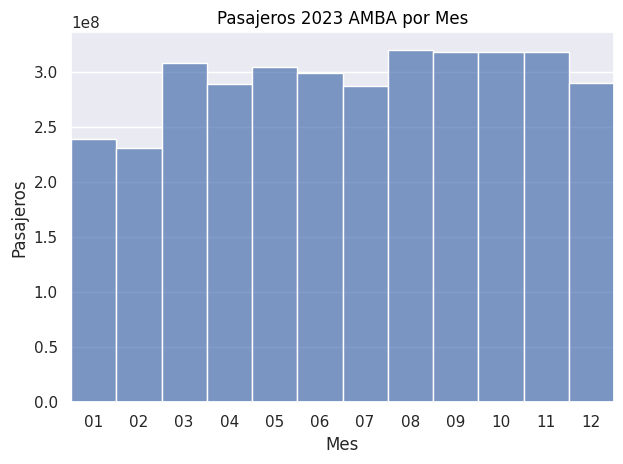

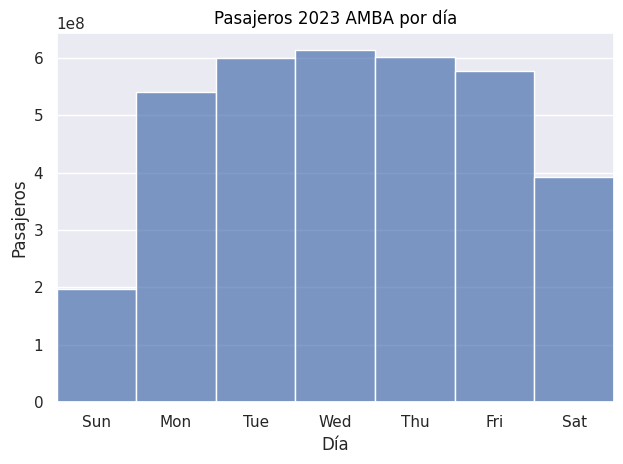

In [17]:
so.Plot(datos_amba, x="fecha_mes", y="pasajeros").add(so.Bars(), so.Agg("sum")).label(title="Pasajeros 2023 AMBA por Mes", x="Mes", y="Pasajeros").show()
so.Plot(datos_amba, x="fecha_dia", y="pasajeros").add(so.Bars(), so.Agg("sum")).label(title="Pasajeros 2023 AMBA por día", x="Día", y="Pasajeros").show()


##### Se ve claramente que en enero y febrero hay menos pasajeros, es algo de esperar suponiendo que muchas personas se toman vacaciones + receso escolar y universitario y una disminucion del uso del transporte publico los fines de seman


In [18]:
# Ahora respondamos cual es la varianza de la cantidad de pasajeros en el AMBA durante el año 2023
varianza_amba = datos_amba['pasajeros'].var()
print(f"La varianza de la cantidad de pasajeros en el AMBA durante el año 2023 es: {varianza_amba}")
# Ahora comparamos con la varianza en el resto de Argentina
datos_no_amba = datos[datos["AMBA"] == "NO"].dropna()
varianza_no_amba = datos_no_amba["CANTIDAD"].var()
print(f"La varianza de la cantidad de pasajeros en el resto de Argentina durante el año 2023 es: {varianza_no_amba}")

print(f"La varianza del amba es {round(varianza_amba/varianza_no_amba, 2)} mayor a la del resto de Argentina")


La varianza de la cantidad de pasajeros en el AMBA durante el año 2023 es: 1016641795.3922949
La varianza de la cantidad de pasajeros en el resto de Argentina durante el año 2023 es: 13214597.424147764
La varianza del amba es 76.93 mayor a la del resto de Argentina


##### Esto nos da una pista de la distribucion de los datos en el AMBA! se ve que los datos estan "Muy alejados entre si" en relacion al resto del país

#####¿Cuál es el medio más utilizado y su proporción? ¿A qué se debe? ¿Será que posee mas lineas/empresas que el resto?

##### ¿A qué se debe? ¿Será que posee mas lineas/empresas que el resto?

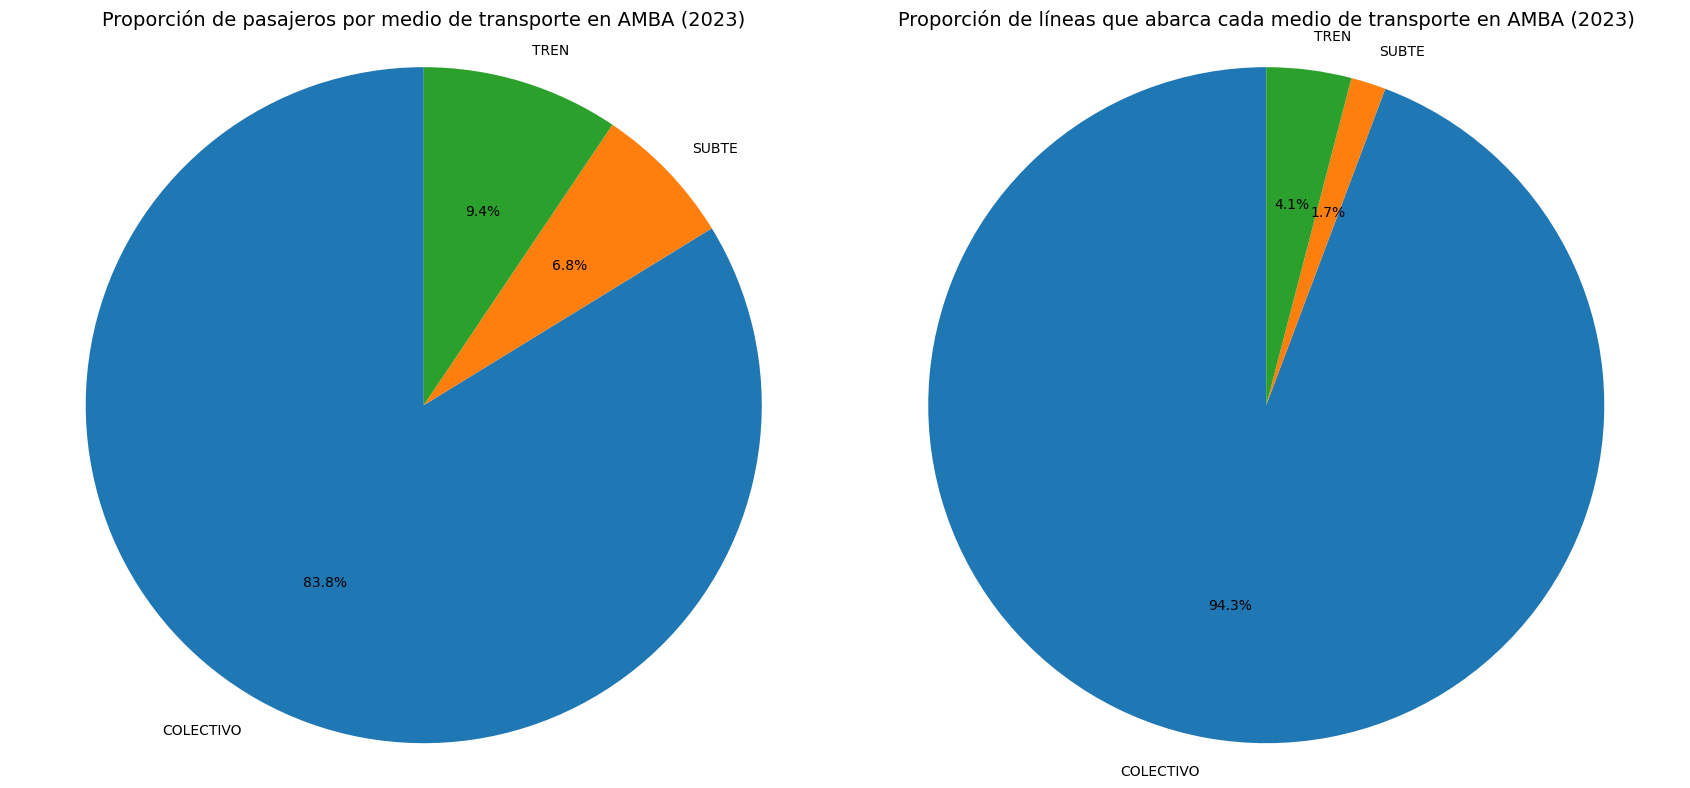

In [19]:
# Calculamos la proporción de pasajeros por cada tipo de transporte
proporcion_transporte = datos_amba.groupby('tipo_transporte')['pasajeros'].sum().reset_index()
proporcion_transporte['proporcion'] = proporcion_transporte['pasajeros'] / datos_amba['pasajeros'].sum()

# Calcular la proporción de líneas que abarcan cada tipo de transporte
lineas_por_transporte_amba = datos_amba.groupby('tipo_transporte')['linea'].nunique().reset_index()
lineas_por_transporte_amba.columns = ['tipo_transporte', 'cantidad']

total_lineas_amba = lineas_por_transporte_amba['cantidad'].sum()
lineas_por_transporte_amba['proporcion'] = lineas_por_transporte_amba['cantidad'] / total_lineas_amba


fig, axs = plt.subplots(1, 2, figsize=(17, 8))

# Gráfico de torta para la proporción de pasajeros
axs[0].pie(proporcion_transporte['proporcion'], labels=proporcion_transporte['tipo_transporte'], autopct='%1.1f%%', startangle=90)
axs[0].set_title('Proporción de pasajeros por medio de transporte en AMBA (2023)', fontsize=14)
axs[0].axis('equal')

# Gráfico de torta para la proporción de líneas
axs[1].pie(lineas_por_transporte_amba['proporcion'], labels=lineas_por_transporte_amba['tipo_transporte'], autopct='%1.1f%%', startangle=90)
axs[1].set_title('Proporción de líneas que abarca cada medio de transporte en AMBA (2023)', fontsize=14)
axs[1].axis('equal')


plt.tight_layout()
plt.show()

#### Parecería indicar que el colectivo es el transporte que mayor movilidad de personas posee en función de la cantidad de líneas que abarca y ofrece en sus servicios. Ahora bien, nos preguntamos lo siguiente:
 ¿Cuál es la movilidad de personas que posee cada tipo de transporte en función de las líneas/servicios que posee?

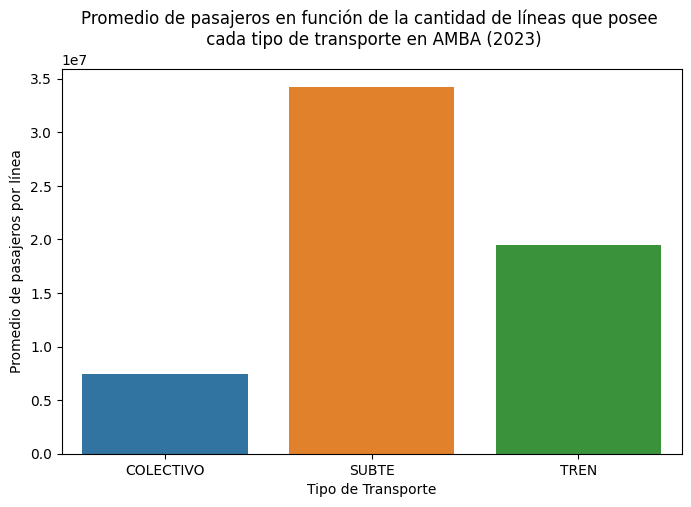

In [20]:
# Calculamos el promedio de pasajeros en función de la cantidad de líneas que tiene cada tipo de transporte
pasajeros_por_linea = proporcion_transporte.merge(lineas_por_transporte_amba, on='tipo_transporte')
pasajeros_por_linea['pasajeros_por_linea'] = pasajeros_por_linea['pasajeros'] / pasajeros_por_linea['cantidad']

plt.figure(figsize=(8, 5))
grafico = sns.barplot(data=pasajeros_por_linea,x="tipo_transporte",y="pasajeros_por_linea",hue="tipo_transporte",)
plt.title("Promedio de pasajeros en función de la cantidad de líneas que posee \n cada tipo de transporte en AMBA (2023)")
plt.xlabel("Tipo de Transporte")
plt.ylabel("Promedio de pasajeros por línea")
plt.show()

Es decir, podemos ver que el SUBTE en líneas generales es el que menor movilidad de personas posee en el año, pero a nivel de cantidad de líneas/servicios que ofrece es el que mayor cantidad de personas abarca en promedio. Esto puede deberse a una mayor eficiencia en términos de distancias recorridas/tiempos/costos

#### ¿Cúales son las empresas que poseen la mayor cantidad de pasajeros a nivel colectivos?

In [21]:
datos_2023 = pd.read_csv('sube-2023.csv')
datos_2023['DIA_TRANSPORTE'] = pd.to_datetime(datos_2023['DIA_TRANSPORTE'], format='%Y-%m-%d')
datos_2023['fecha_dia'] = datos_2023['DIA_TRANSPORTE'].dt.day_name().str[:3]
datos_2023['fecha_mes'] = datos_2023['DIA_TRANSPORTE'].dt.strftime('%m')
datos_2023['fecha_ordinal'] = datos_2023['DIA_TRANSPORTE'].dt.dayofyear
datos_2023 = datos_2023.rename(columns = {"DIA_TRANSPORTE" : "fecha", "CANTIDAD" : "pasajeros"})
datos_2023 = datos_2023.rename(columns = str.lower)


In [22]:
colectivos = datos_2023[(datos_2023['amba'] == 'SI') & (datos_2023['dato_preliminar'] == "NO") & (datos_2023['tipo_transporte'] == "COLECTIVO")]

In [23]:
# Agrupo por nombre de empresa y cuento la cantidad de pasajeros que acumuló cada empresa
pasajeros_por_empresa = colectivos.groupby('nombre_empresa')['pasajeros'].sum().reset_index()
pasajeros_por_empresa.columns = ['nombre_empresa', 'total_de_pasajeros']

# Agrupo por nombre de empresa y cuento la cantidad de líneas que posee cada empresa
lineas_por_empresa = colectivos.groupby('nombre_empresa')['linea'].nunique().reset_index()
lineas_por_empresa.columns = ['nombre_empresa', 'cantidad_de_líneas']

# Agrupo por nombre de empresa y listo a los municipios que recorre cada empresa
lineas_por_empresa_lista = colectivos.groupby('nombre_empresa')['linea'].apply(lambda x: list(set(x))).reset_index()
lineas_por_empresa_lista.columns = ['nombre_empresa', 'lineas']

# Agrupo por nombre de empresa y cuento la cantidad de municipios que recorre cada empresa
zonas_por_empresa = colectivos.groupby('nombre_empresa')['municipio'].nunique().reset_index()
zonas_por_empresa.columns = ['nombre_empresa', 'cantidad_de_municipios']

# Agrupo por nombre de empresa y listo a los municipios que recorre cada empresa
municipios_por_empresa_lista = colectivos.groupby('nombre_empresa')['municipio'].apply(lambda x: list(set(x))).reset_index()
municipios_por_empresa_lista.columns = ['nombre_empresa', 'municipios']

# Uno el DataFrame de pasajeros_por_empresa y lineas_por_empresa en uno parcial
resultados_parciales = pd.merge(pasajeros_por_empresa, lineas_por_empresa, on='nombre_empresa')

# Uno el DataFrame de resultados_parciales y lineas_por_empresa_lista en uno parcial
resultados_parciales2 = pd.merge(resultados_parciales, lineas_por_empresa_lista, on='nombre_empresa')

# Uno el DataFrame de resultados_parciales2 y municipios_por_empresa_lista en uno parcial
resultados_parciales3 = pd.merge(resultados_parciales2, municipios_por_empresa_lista, on='nombre_empresa')

# Uno el DataFrame de resultados_parciales3 y zonas_por_empresa.
resultados_por_empresa = pd.merge(resultados_parciales3, zonas_por_empresa, on='nombre_empresa')

# Ordeno el DataFrame por orden de cantidad total de pasajeros
resultados_por_empresa = resultados_por_empresa.sort_values(by='total_de_pasajeros', ascending=False)

top_5_empresas = resultados_por_empresa.head(5)
top_5_empresas

,nombre_empresa,total_de_pasajeros,cantidad_de_líneas,lineas,municipios,cantidad_de_municipios
132,TRANSPORTES LA PERLITA S.A.,91144040,7,"[BSAS_LINEA_501G, BSAS_LINEA_311, BSAS_LINEA_5...","[GENERAL RODRIGUEZ, SN, MORENO]",3
40,EMPRESA LINEA 216 S.A.T.,85937290,9,"[LINEA_504_ ITUZ, BSAS_LINEA_166, BSAS_LINEA_4...","[MERLO, MORON, SN, SD, ITUZAINGO]",5
63,LA CABAÑA S.A.,66374356,7,"[BSAS_LINEA_635, BSAS_LINEA_624, BSAS_LINEA_29...","[MORON, SN, LA MATANZA, SD]",4
60,GENERAL TOMAS GUIDO S.A.C.I.F.,62128231,9,"[BSAS_LINEA_271, BSAS_LINEA_384, LINEA_164_AMB...","[SN, SD, AVELLANEDA]",3
66,LA NUEVA METROPOL S.A.,54419476,5,"[BSAS_LINEA_228A, BSAS_LINEA_365, BSAS_LINEA_1...","[SN, SD]",2


In [24]:
municipios_expandidos = top_5_empresas.explode('municipios')
municipio_frecuencias = municipios_expandidos['municipios'].value_counts().reset_index()
municipio_frecuencias.columns = ['municipio', 'repeticiones']
municipio_frecuencias

,municipio,repeticiones
0,SN,5
1,SD,4
2,MORON,2
3,GENERAL RODRIGUEZ,1
4,MORENO,1
5,MERLO,1
6,ITUZAINGO,1
7,LA MATANZA,1
8,AVELLANEDA,1


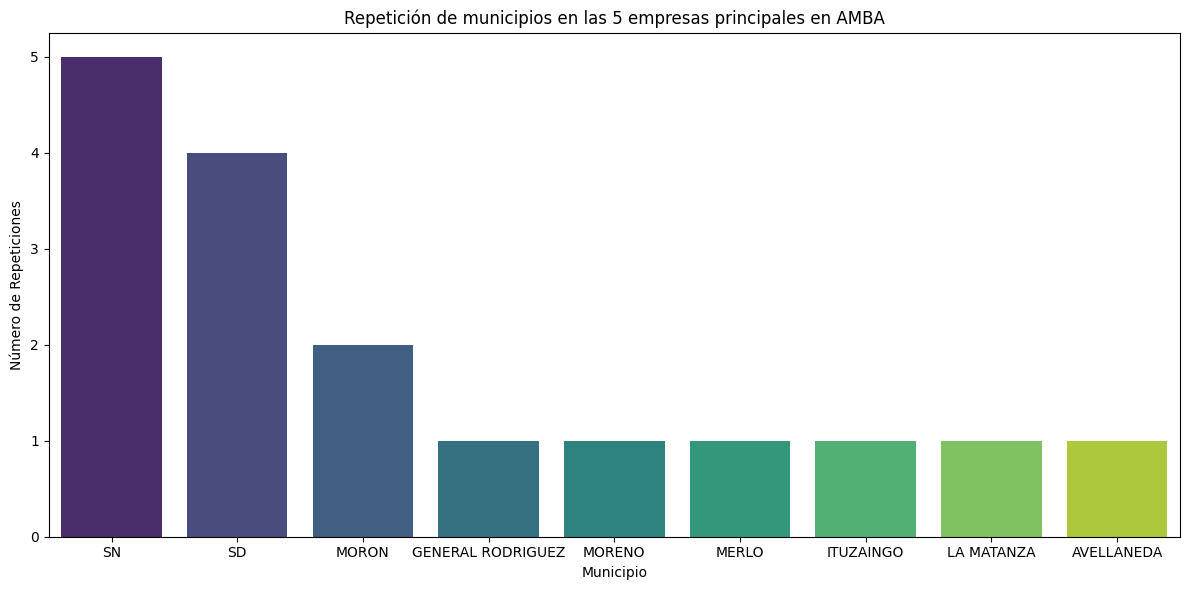

In [25]:
plt.figure(figsize=(12, 6))
sns.barplot(data= municipio_frecuencias, x='municipio', y='repeticiones', hue = 'municipio',palette='viridis')
plt.title('Repetición de municipios en las 5 empresas principales en AMBA')
plt.xlabel('Municipio')
plt.ylabel('Número de Repeticiones')
plt.tight_layout()
plt.show()

In [26]:
#Veo como se encuentran escritos los nombres
print(top_5_empresas['nombre_empresa'].unique())

['TRANSPORTES LA PERLITA S.A. ' 'EMPRESA LINEA 216 S.A.T.'
 'LA CABAÑA S.A.' 'GENERAL TOMAS GUIDO S.A.C.I.F.'
 'LA NUEVA METROPOL S.A.']


In [27]:
nombre_empresa_especifica = "GENERAL TOMAS GUIDO S.A.C.I.F."
empresa_especifica = top_5_empresas[top_5_empresas['nombre_empresa'] == nombre_empresa_especifica]
print(f"Líneas que recorre la empresa {nombre_empresa_especifica}:")
print(empresa_especifica['lineas'].values[0])


Líneas que recorre la empresa GENERAL TOMAS GUIDO S.A.C.I.F.:
['BSAS_LINEA_271', 'BSAS_LINEA_384', 'LINEA_164_AMBA', 'BSAS_LINEA_084', 'BSAS_LINEA_299', 'BSAS_LINEA_25', 'BSAS_LINEA_009', 'BSAS_LINEA_373', 'BSAS_LINEA_570']


In [120]:
nombre_linea_especifica = "BSAS_LINEA_009"
empresas_con_linea_especifica = resultados_por_empresa[resultados_por_empresa['lineas'].apply(lambda x: nombre_linea_especifica in x)]
empresa_encontrada = empresas_con_linea_especifica['nombre_empresa'].values[0]
print(f"La empresa que posee la línea {nombre_linea_especifica} es: {empresa_encontrada}")
empresas_con_linea_especifica

La empresa que posee la línea BSAS_LINEA_009 es: GENERAL TOMAS GUIDO S.A.C.I.F.


,nombre_empresa,total_de_pasajeros,cantidad_de_líneas,lineas,municipios,cantidad_de_municipios
60,GENERAL TOMAS GUIDO S.A.C.I.F.,62128231,9,"[BSAS_LINEA_271, BSAS_LINEA_384, LINEA_164_AMB...","[SN, SD, AVELLANEDA]",3


####(Tal vez podríamos ver si estas empresas y las líneas que poseen comparten municipios en común, para determinar zonas claves de movimiento) y realizar otro mapita :)

#### Modelado

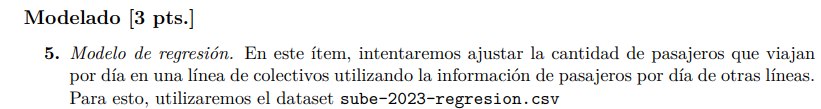

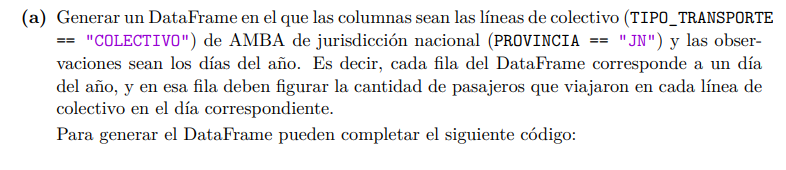

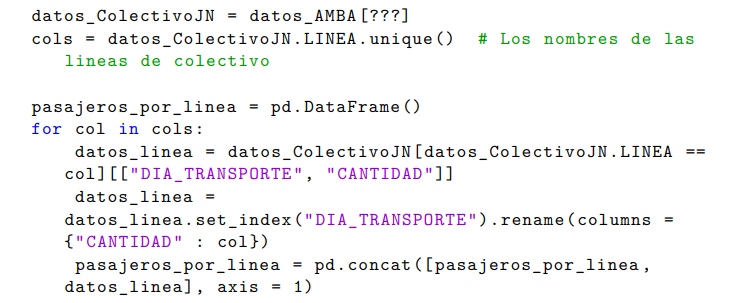

In [408]:
datos_regresion = pd.read_csv('sube-2023-regresion.csv')

In [410]:
datos_regresion

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO
2,2023-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1707,NO
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO
4,2023-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1189,NO
...,...,...,...,...,...,...,...,...,...,...
323321,2023-12-30,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL A,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,135,NO
323322,2023-12-30,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL B,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,131,NO
323323,2023-12-30,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL C,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,133,NO
323324,2023-12-30,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL D,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,139,NO


In [411]:
datos_ColectivoJN = datos_regresion[(datos_regresion['AMBA'] == 'SI') & (datos_regresion['PROVINCIA'] == 'JN') & (datos_regresion['TIPO_TRANSPORTE'] == 'COLECTIVO')]


cols = datos_ColectivoJN['LINEA'].unique()
pasajeros_por_linea = pd.DataFrame()

for col in cols:
    datos_linea = datos_ColectivoJN[datos_ColectivoJN['LINEA'] == col][['DIA_TRANSPORTE', 'CANTIDAD']]
    datos_linea = datos_linea.set_index('DIA_TRANSPORTE').rename(columns={'CANTIDAD': col})
    pasajeros_por_linea = pd.concat([pasajeros_por_linea, datos_linea], axis=1)


In [412]:
pasajeros_por_linea

,BS_ASLINEA_123,BSAS_LINEA_002,BSAS_LINEA_009,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_019,BSAS_LINEA_020,BSAS_LINEA_021,BSAS_LINEA_022,...,LINEA 5,LINEA 50,LINEA 6,LINEA 7,LINEA 76,LINEA 8,LINEA_099,LINEA_119_AMBA,LINEA_164_AMBA,LINEA 119
DIA_TRANSPORTE,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1681,5670,5644,5177,9109,7013,1604,2617,11235,2202,...,4832.0,4839,2449,2184,3797,5317,1882,1573.0,3210,NaN
2023-01-02,9440,21759,23284,21176,45269,29962,13921,11934,55611,13823,...,20333.0,16221,10486,12774,17374,23250,10322,7345.0,19362,NaN
2023-01-04,10540,24755,25405,23806,52873,33659,16172,13366,61721,16206,...,23041.0,18448,12193,13949,19860,26294,11981,7925.0,21784,NaN
2023-01-05,10408,25772,26489,24688,53436,35182,16569,12929,62510,16863,...,23928.0,18481,12888,14668,21235,27216,11787,7597.0,22972,NaN
2023-01-06,10530,26021,26458,24167,53163,35212,16459,12955,63528,16846,...,24247.0,19300,12703,14199,23472,27073,11567,7811.0,23411,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,15957,35664,26684,31803,65544,47601,23197,16051,67748,24169,...,NaN,25838,16870,19426,28628,62260,15823,NaN,30177,13488.0
2023-12-23,8844,24236,19188,19964,43408,31986,12357,9859,50972,14347,...,NaN,13817,7896,9332,21468,43152,8991,NaN,16025,9699.0
2023-12-27,12721,29591,24693,29374,60347,41283,19417,14498,60169,22126,...,NaN,21545,13454,14923,25542,51921,11385,NaN,16931,13262.0


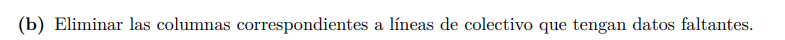

In [405]:
pasajeros_por_linea.isnull().values.any() #Este comando nos indica si hay valores nulos

True

In [413]:
# Eliminamos las columnas con datos faltantes
pasajeros_por_linea = pasajeros_por_linea.dropna(axis = 1)
# Chequeamos que no hayan quedado valores nulos
pasajeros_por_linea.isnull().values.any()
pasajeros_por_linea

,BS_ASLINEA_123,BSAS_LINEA_002,BSAS_LINEA_009,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_019,BSAS_LINEA_020,BSAS_LINEA_021,BSAS_LINEA_022,...,LINEA 4,LINEA 42,LINEA 44,LINEA 50,LINEA 6,LINEA 7,LINEA 76,LINEA 8,LINEA_099,LINEA_164_AMBA
DIA_TRANSPORTE,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1681,5670,5644,5177,9109,7013,1604,2617,11235,2202,...,2942,4029,4649,4839,2449,2184,3797,5317,1882,3210
2023-01-02,9440,21759,23284,21176,45269,29962,13921,11934,55611,13823,...,15329,19072,20387,16221,10486,12774,17374,23250,10322,19362
2023-01-04,10540,24755,25405,23806,52873,33659,16172,13366,61721,16206,...,17836,21609,23595,18448,12193,13949,19860,26294,11981,21784
2023-01-05,10408,25772,26489,24688,53436,35182,16569,12929,62510,16863,...,18044,21993,23687,18481,12888,14668,21235,27216,11787,22972
2023-01-06,10530,26021,26458,24167,53163,35212,16459,12955,63528,16846,...,18122,22421,23731,19300,12703,14199,23472,27073,11567,23411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,15957,35664,26684,31803,65544,47601,23197,16051,67748,24169,...,22421,30098,29079,25838,16870,19426,28628,62260,15823,30177
2023-12-23,8844,24236,19188,19964,43408,31986,12357,9859,50972,14347,...,14508,17630,19431,13817,7896,9332,21468,43152,8991,16025
2023-12-27,12721,29591,24693,29374,60347,41283,19417,14498,60169,22126,...,19319,25010,26433,21545,13454,14923,25542,51921,11385,16931


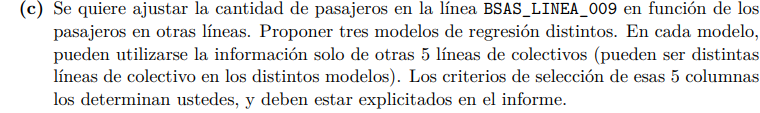

In [415]:
pasajeros = pasajeros_por_linea.div(pasajeros_por_linea.max())
pasajeros

,BS_ASLINEA_123,BSAS_LINEA_002,BSAS_LINEA_009,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_019,BSAS_LINEA_020,BSAS_LINEA_021,BSAS_LINEA_022,...,LINEA 4,LINEA 42,LINEA 44,LINEA 50,LINEA 6,LINEA 7,LINEA 76,LINEA 8,LINEA_099,LINEA_164_AMBA
DIA_TRANSPORTE,,,,,,,,,,,,,,,,,,,,,
2023-01-01,0.103319,0.147391,0.132138,0.143047,0.131104,0.138135,0.062495,0.095195,0.129099,0.085118,...,0.116239,0.100159,0.126617,0.163386,0.100567,0.093317,0.120086,0.085400,0.089756,0.080985
2023-01-02,0.580209,0.565624,0.545127,0.585118,0.651549,0.590163,0.542391,0.434106,0.639016,0.534325,...,0.605650,0.474121,0.555247,0.547692,0.430601,0.545804,0.549480,0.373434,0.492274,0.488483
2023-01-04,0.647818,0.643505,0.594784,0.657788,0.760993,0.662983,0.630094,0.486195,0.709225,0.626440,...,0.704702,0.537190,0.642618,0.622886,0.500698,0.596009,0.628103,0.422326,0.571395,0.549588
2023-01-05,0.639705,0.669942,0.620162,0.682159,0.769096,0.692982,0.645562,0.470299,0.718291,0.651836,...,0.712920,0.546736,0.645124,0.624000,0.529238,0.626730,0.671590,0.437135,0.562142,0.579560
2023-01-06,0.647203,0.676415,0.619437,0.667763,0.765166,0.693573,0.641276,0.471245,0.729989,0.651179,...,0.716002,0.557376,0.646322,0.651653,0.521641,0.606691,0.742338,0.434838,0.551650,0.590635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.980762,0.927084,0.624728,0.878754,0.943364,0.937600,0.903803,0.583864,0.778480,0.934248,...,0.885855,0.748223,0.791976,0.872404,0.692756,0.830029,0.905405,1.000000,0.754626,0.761334
2023-12-23,0.543577,0.630014,0.449231,0.551629,0.624764,0.630030,0.481454,0.358626,0.585710,0.554581,...,0.573212,0.438274,0.529210,0.466523,0.324244,0.398735,0.678959,0.693093,0.428796,0.404294
2023-12-27,0.781868,0.769217,0.578114,0.811638,0.868565,0.813154,0.756526,0.527373,0.691391,0.855276,...,0.763295,0.621737,0.719912,0.727454,0.552480,0.637626,0.807805,0.833938,0.542970,0.427151


In [416]:
pasajeros.columns = pasajeros.columns.str.replace(' ', '_').str.replace('.', '_')

target_line = 'BSAS_LINEA_009'
other_lines = [col for col in pasajeros.columns if col != target_line]
formula1 = f'{target_line} ~ ' + ' + '.join(other_lines)


In [437]:
y1, X1 =  Formula(formula1).get_model_matrix(pasajeros)
y = y1.squeeze()

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

modeloLineal1 = linear_model.LinearRegression(fit_intercept = False)

modeloLineal1.fit(X_train, y_train)

y_pred = modeloLineal1.predict(X_test)

print("Coeficientes:", modeloLineal1.coef_)
r2 = r2_score(y_test, y_pred)
print('R^2: ', r2)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Raiz del Error Cuadratico Medio: {rmse:.5f}")

Coeficientes: [[ 0.01744676 -0.05998292  0.413751   -0.08048917  0.16541506 -0.29579563
  -0.26204954  0.01738924  0.03549873 -0.04660216  0.21075237 -0.29234214
  -0.08204012  0.09532231  0.21377959  0.17613768  0.06031657 -0.15357822
   0.1633061   0.04359759  0.01365785  0.04876138 -0.05811783 -0.36305786
  -0.34109511 -0.15108007  0.0052943  -0.12947705 -0.03757196 -0.01805682
  -0.0464895   0.00664404 -0.24199542 -0.10962038  0.59858869 -0.05219422
  -0.27000497 -0.06864061 -0.06843136 -0.01518538 -0.14294651  0.23818185
  -0.06995591  0.32639746 -0.13835408  0.15908833 -0.04666948  0.21234745
  -0.00957069 -0.15568434 -0.07143135 -0.26245462  0.19641351  0.19193279
   0.39614515  0.39421638  0.66934962 -0.04654079 -0.08963645  0.20439627
   0.61964288 -0.68698736  0.47116592 -0.17662331  0.05795106  0.02652982
  -0.15114068  0.04660813  0.34801505 -0.27401116  0.07423064  0.03979306
  -0.41480886  0.14364456 -0.06317659  0.38416271 -0.01648334  0.36257077
   0.17376669  0.0560326

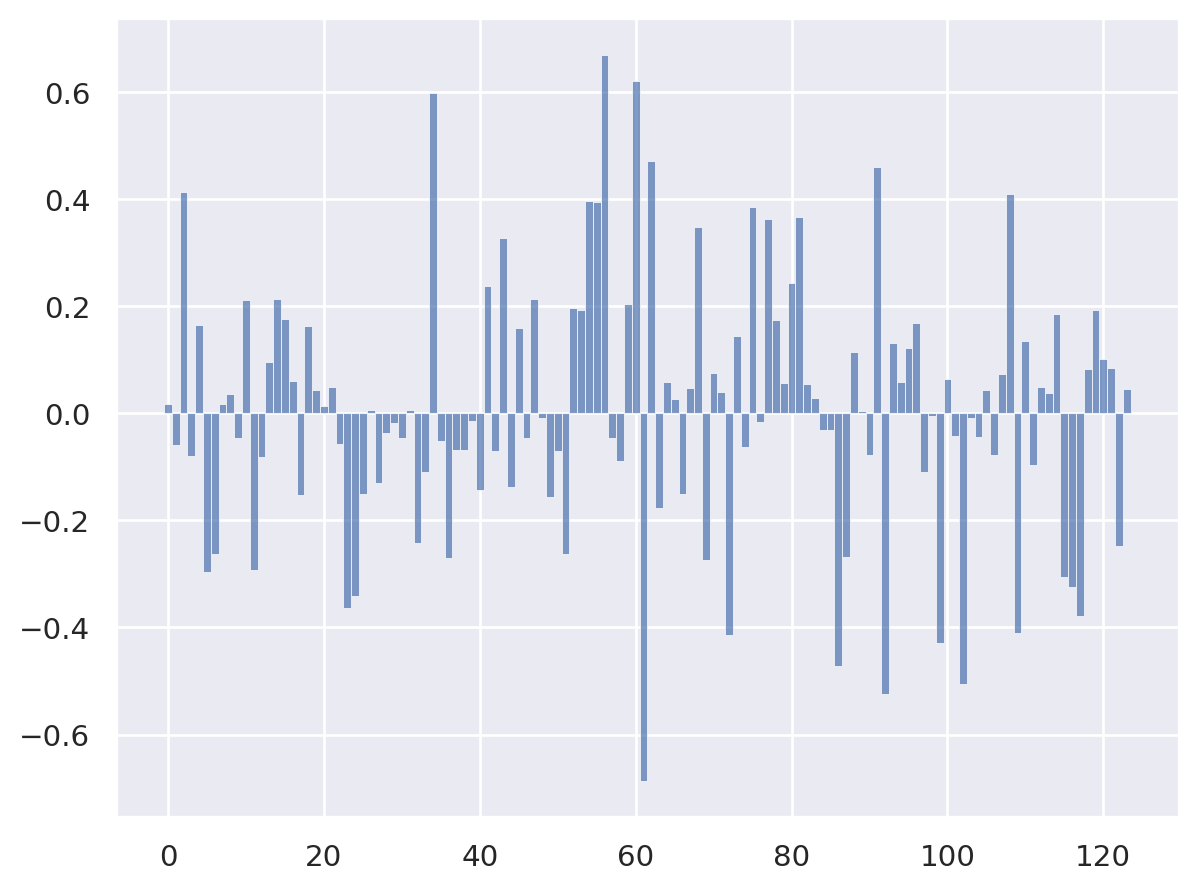

In [429]:
coeficientes = modeloLineal1.coef_.flatten()
coeficientes

(
    so.Plot(x = np.array(range(len(coeficientes))), y = coeficientes )
    .add(so.Bars())
)


In [431]:

lineas_coeficientes = pd.DataFrame({'Línea': X1.columns, 'Coeficiente': coeficientes})
lineas_seleccionadas = lineas_coeficientes.reindex(lineas_coeficientes['Coeficiente'].abs().sort_values(ascending=False).index[:5])
print("Líneas seleccionadas:", lineas_seleccionadas)

Líneas seleccionadas:              Línea  Coeficiente
61  BSAS_LINEA_110    -0.686987
56  BSAS_LINEA_103     0.669350
60  BSAS_LINEA_109     0.619643
34  BSAS_LINEA_068     0.598589
92  BSAS_LINEA_172    -0.523838


In [432]:
formula2 = 'BSAS_LINEA_009 ~ BSAS_LINEA_110  + BSAS_LINEA_103 + BSAS_LINEA_109 + BSAS_LINEA_068 + BSAS_LINEA_172'

In [433]:
y2, X2 =  Formula(formula2).get_model_matrix(pasajeros)
y = y2.squeeze()


X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)


modeloLineal = linear_model.LinearRegression(fit_intercept = False)


modeloLineal.fit(X_train, y_train)


y_pred = modeloLineal.predict(X_test)


print("Coeficientes:", modeloLineal.coef_)
r2 = r2_score(y_test, y_pred)
print('R^2: ', r2)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Raiz del Error Cuadratico Medio: {rmse:.5f}")

Coeficientes: [[ 0.08814413  0.22286083  0.46930724  0.21882143 -0.41695528  0.27099939]]
R^2:  0.7782684991169967
Raiz del Error Cuadratico Medio: 0.10793


In [434]:
#Ridge

# Entrenamiento y testeo
df_train, df_test = train_test_split(pasajeros, test_size=0.2, random_state=42)
formula2 = 'BSAS_LINEA_009 ~ BSAS_LINEA_110  + BSAS_LINEA_103 + BSAS_LINEA_109 + BSAS_LINEA_068 + BSAS_LINEA_172'

# Construimos las matrices X e y para entrenamiento
y, X =  Formula(formula2).get_model_matrix(df_train)

alphas = np.array([0.01, 0.1, 0.5, 1,2,3])
cv = KFold(n_splits=5, random_state=42, shuffle=True)  # 5 pliegos
for alpha in alphas:
    # Inicializamos un modelo de Regresion Lineal sin intercept
    modeloRidge = linear_model.Ridge(alpha = alpha, fit_intercept = False)
    rmse = np.zeros(cv.get_n_splits())  # Vamos a guardar el error en cada pliego

    ind = 0

    # Para seleccionar algunas filas dados los índices, utilizamos iloc (lo vimos en la clase 2)
    for train_index, val_index in cv.split(X):
        X_train, X_val, y_train, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
        modeloRidge.fit(X_train, y_train)

        y_pred = modeloRidge.predict(X_val)
        rmse[ind] = np.sqrt(mean_squared_error(y_val, y_pred))
        ind = ind + 1

    print(f"Para alpha = {alpha:.5f} la raíz del Error Cuadratico Medio es: {rmse.mean():.5f}")

Para alpha = 0.01000 la raíz del Error Cuadratico Medio es: 0.06442
Para alpha = 0.10000 la raíz del Error Cuadratico Medio es: 0.06269
Para alpha = 0.50000 la raíz del Error Cuadratico Medio es: 0.06438
Para alpha = 1.00000 la raíz del Error Cuadratico Medio es: 0.06590
Para alpha = 2.00000 la raíz del Error Cuadratico Medio es: 0.06744
Para alpha = 3.00000 la raíz del Error Cuadratico Medio es: 0.06845


El valor óptimo es alpha = 0.10000 En base a los resultados observados agregamos algunos valores de alpha cercanos a 0.10000

In [435]:
alphas = [0.09500, 0.09600, 0.09700, 0.09800, 0.09900, 0.10000, 0.10100, 0.10200, 0.10300, 0.10400, 0.10500, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700, 0.1800, 0.1900, 0.1999]

for alpha in alphas:
    modeloRidge = linear_model.Ridge(alpha = alpha, fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
    rmse = np.zeros(cv.get_n_splits())  # Vamos a guardar el error en cada pliego

    ind = 0

    # Para seleccionar algunas filas dados los índices, utilizamos iloc (lo vimos en la clase 2)
    for train_index, val_index in cv.split(X):
        X_train, X_val, y_train, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
        modeloRidge.fit(X_train, y_train)

        y_pred = modeloRidge.predict(X_val)
        rmse[ind] = np.sqrt(mean_squared_error(y_val, y_pred))
        ind = ind + 1

    print(f"Para alpha = {alpha:.5f} la raiz del error cuadratico medio es: {rmse.mean():.5f}")


Para alpha = 0.09500 la raiz del error cuadratico medio es: 0.06271
Para alpha = 0.09600 la raiz del error cuadratico medio es: 0.06271
Para alpha = 0.09700 la raiz del error cuadratico medio es: 0.06270
Para alpha = 0.09800 la raiz del error cuadratico medio es: 0.06270
Para alpha = 0.09900 la raiz del error cuadratico medio es: 0.06270
Para alpha = 0.10000 la raiz del error cuadratico medio es: 0.06269
Para alpha = 0.10100 la raiz del error cuadratico medio es: 0.06269
Para alpha = 0.10200 la raiz del error cuadratico medio es: 0.06269
Para alpha = 0.10300 la raiz del error cuadratico medio es: 0.06269
Para alpha = 0.10400 la raiz del error cuadratico medio es: 0.06268
Para alpha = 0.10500 la raiz del error cuadratico medio es: 0.06268
Para alpha = 0.12000 la raiz del error cuadratico medio es: 0.06267
Para alpha = 0.13000 la raiz del error cuadratico medio es: 0.06267
Para alpha = 0.14000 la raiz del error cuadratico medio es: 0.06269
Para alpha = 0.15000 la raiz del error cuadratic

In [436]:
alpha_optimo = 0.13000

modeloRidge = linear_model.Ridge(alpha = alpha_optimo, fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modeloRidge.fit(X, y)

# Construimos las matrices X e y para entrenamiento
formula= 'BSAS_LINEA_009 ~ BSAS_LINEA_110  + BSAS_LINEA_103 + BSAS_LINEA_109 + BSAS_LINEA_068 + BSAS_LINEA_172'
y_test, X_test =  Formula(formula).get_model_matrix(df_test)

y_pred = modeloRidge.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"For alpha = {alpha_optimo:.5f} the Root Mean Squared Error is: {rmse.mean():.5f}")
r2 = r2_score(y_test, y_pred)
print('R^2: ', r2)

For alpha = 0.13000 the Root Mean Squared Error is: 0.10688
R^2:  0.7825823194529309
